In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
import torch
import polars as pl
from torch.utils.data import DataLoader, Dataset
import torch_geometric
from torch_geometric.data import Data, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Upload the data

In [11]:
def load_data(source) -> pl.DataFrame:
    return pl.read_csv(source = source, truncate_ragged_lines = True)

In [12]:
#Load the data
train_sequences = load_data(source = "/home/mich02/Desktop/Kaggle/data/train_sequences.csv")
train_labels = load_data(source = "/home/mich02/Desktop/Kaggle/data/train_labels.csv")
test_sequences = load_data(source = "/home/mich02/Desktop/Kaggle/data/test_sequences.csv")
valid_sequences = load_data(source = "/home/mich02/Desktop/Kaggle/data/validation_sequences.csv")
valid_labels = load_data(source = "/home/mich02/Desktop/Kaggle/data/validation_labels.csv")
sample_submission = load_data(source = "/home/mich02/Desktop/Kaggle/data/sample_submission.csv")

#Check for N/A
datasets = {
    "Train Sequences": train_sequences,
    "Train Labels": train_labels,
    "Test Sequences": test_sequences,
    "Validation Sequences": valid_sequences,
    "Validation Labels": valid_labels,
}

for name, df in datasets.items():
    null_counts = df.null_count().sum()
    print(f"N/A count for {name}: {null_counts}")

N/A count for Train Sequences: shape: (1, 5)
┌───────────┬──────────┬─────────────────┬─────────────┬───────────────┐
│ target_id ┆ sequence ┆ temporal_cutoff ┆ description ┆ all_sequences │
│ ---       ┆ ---      ┆ ---             ┆ ---         ┆ ---           │
│ u32       ┆ u32      ┆ u32             ┆ u32         ┆ u32           │
╞═══════════╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 0         ┆ 0        ┆ 0               ┆ 0           ┆ 5             │
└───────────┴──────────┴─────────────────┴─────────────┴───────────────┘
N/A count for Train Labels: shape: (1, 6)
┌─────┬─────────┬───────┬──────┬──────┬──────┐
│ ID  ┆ resname ┆ resid ┆ x_1  ┆ y_1  ┆ z_1  │
│ --- ┆ ---     ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u32 ┆ u32     ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞═════╪═════════╪═══════╪══════╪══════╪══════╡
│ 0   ┆ 0       ┆ 0     ┆ 6145 ┆ 6145 ┆ 6145 │
└─────┴─────────┴───────┴──────┴──────┴──────┘
N/A count for Test Sequences: shape: (1, 5)
┌───────────┬──────────┬─────

In [13]:
#Fill the N/A with 0 
train_sequences = train_sequences.drop_nulls()
train_labels = train_labels.drop_nulls()
print(train_sequences)
print(train_labels)

shape: (839, 5)
┌───────────┬──────────────────────┬─────────────────┬──────────────────────┬──────────────────────┐
│ target_id ┆ sequence             ┆ temporal_cutoff ┆ description          ┆ all_sequences        │
│ ---       ┆ ---                  ┆ ---             ┆ ---                  ┆ ---                  │
│ str       ┆ str                  ┆ str             ┆ str                  ┆ str                  │
╞═══════════╪══════════════════════╪═════════════════╪══════════════════════╪══════════════════════╡
│ 1SCL_A    ┆ GGGUGCUCAGUACGAGAGGA ┆ 1995-01-26      ┆ THE SARCIN-RICIN     ┆ >1SCL_1|Chain A|RNA  │
│           ┆ ACCGCACCC            ┆                 ┆ LOOP, A MODUL…       ┆ SARCIN-RIC…          │
│ 1RNK_A    ┆ GGCGCAGUGGGCUAGCGCCA ┆ 1995-02-27      ┆ THE STRUCTURE OF AN  ┆ >1RNK_1|Chain A|RNA  │
│           ┆ CUCAAAAGGC…          ┆                 ┆ RNA PSEUDO…          ┆ PSEUDOKNOT…          │
│ 1RHT_A    ┆ GGGACUGACGAUCACGCAGU ┆ 1995-06-03      ┆ 24-MER RNA HAIRPIN  

In [14]:
#Verifying the shape
print(f'The shapes of train data, train targets, test data are \n {train_sequences.shape}, {train_labels.shape}, {test_sequences.shape}')

The shapes of train data, train targets, test data are 
 (839, 5), (130950, 6), (12, 5)


In [15]:
train_sequences = train_sequences.drop(["temporal_cutoff", "description", "all_sequences"])
test_sequences = test_sequences.drop(["description", "all_sequences"])

## Visualize

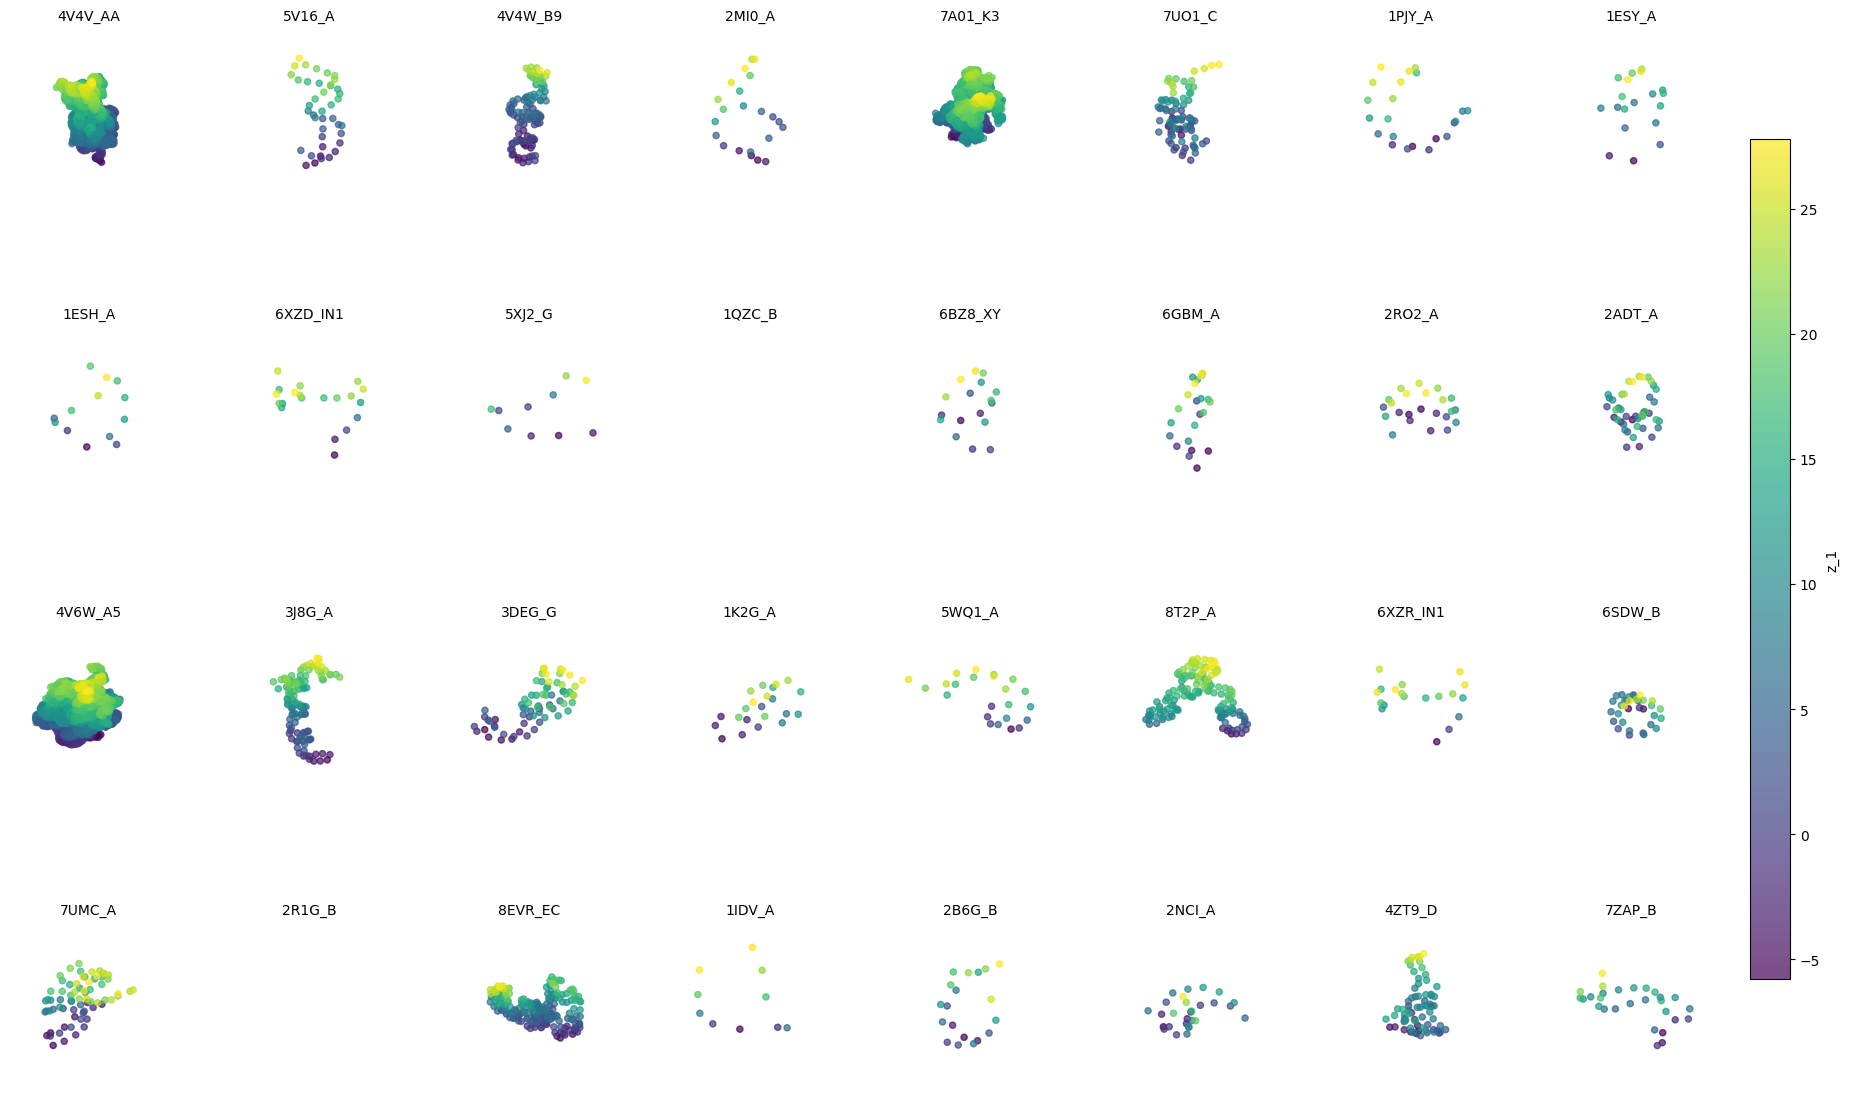

In [16]:
np.random.seed(42)

#Get unique target IDs
unique_target_ids = train_sequences['target_id'].unique().to_list()

#Randomly select 32 target IDs
idx = np.random.choice(len(unique_target_ids), size=32, replace=False)
selected_target_ids = [unique_target_ids[i] for i in idx]

#Create a figure with 4x8 subplots for 3D scatter plots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

#Visualize sample data in 3D scatter plots
for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')  #Hide axis ticks
    
    #Get all labels corresponding to the current target_id
    filtered_data = train_labels.filter(pl.col('ID').str.starts_with(target_id)).sort('resid').to_dict(as_series=False)
    
    #Extract coordinates and residue names
    x = np.array(filtered_data['x_1'], dtype=float)
    y = np.array(filtered_data['y_1'], dtype=float)
    z = np.array(filtered_data['z_1'], dtype=float)
    
    #Create 3D scatter plot
    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.7)
    
    #Set view angle
    axes[i].view_init(elev=30, azim=45)
    
    #Set title
    axes[i].set_title(f'{target_id}', color='black', fontsize=10, pad=10)

#Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
fig.colorbar(sc, cax=cbar_ax, label='z_1', orientation='vertical')

#Adjust layout
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

#Show the plot
plt.show()

## Graph neural network and Diffusion model

****1. Preprocessing: Convert squence to graph****

In [17]:
nucleotide_map ={"A": [1, 0, 0, 0],
                 "U": [0, 1, 0, 0],
                 "G": [0, 0, 1, 0],
                 "C": [0, 0, 0, 1]}

# One-hot encoding of nucleotides
def sequence_to_graph(rna_sequence: str) -> Data:
    node_features = torch.tensor([nucleotide_map.get(nuc, [0, 0, 0, 0]) for nuc in rna_sequence], dtype = torch.float)
    edge_index = torch.tensor([[i, i + 1] for i in range(len(rna_sequence) - 1)], dtype = torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim = 1)
    return Data(x = node_features, edge_index = edge_index)

print(sequence_to_graph(rna_sequence = train_sequences[0,1]))

Data(x=[29, 4], edge_index=[2, 56])


**2. Create a Data Loader**

In [18]:
# RNA_Graph_Dataset
class RNA_Graph_Dataset(Dataset):
    def __init__(self, train_sequences: pl.DataFrame, train_labels: pl.DataFrame):
        self.train_sequences = train_sequences

        # Create target_id column from ID (e.g., "1SCL_A_1" → "1SCL_A")
        self.train_labels = train_labels.with_columns([
            (pl.col("ID").str.split("_").list.get(0) + "_" + pl.col("ID").str.split("_").list.get(1)).alias("target_id")
        ])

        # Only keep sequences with matching labels
        valid_ids = self.train_labels.select("target_id").unique().get_column("target_id")
        self.train_sequences = self.train_sequences.filter(
            pl.col("target_id").is_in(valid_ids)
        )

        # Preload rows for fast access
        self.seq_rows = self.train_sequences.rows(named=True)

    def __len__(self):
        return len(self.seq_rows)

    def __getitem__(self, idx):
        row = self.seq_rows[idx]
        target_id = row["target_id"]
        sequence = row["sequence"]

        graph = sequence_to_graph(sequence)

        # Get corresponding coordinates
        label_rows = self.train_labels.filter(pl.col("target_id") == target_id).sort("resid")
        coords = torch.tensor(label_rows.select(["x_1", "y_1", "z_1"]).to_numpy(), dtype=torch.float)

        assert coords.shape[0] == graph.x.shape[0], f"Mismatch in length for {target_id}"
        graph.y = coords
        graph.target_id = target_id  # Add ID for traceability
        return graph

In [19]:
dataset = RNA_Graph_Dataset(train_sequences, train_labels)

# Print the first sample
sample = dataset[0]
print(sample)
print(sample.x.shape)        # Node features
print(sample.y.shape)        # 3D coordinates
print(sample.edge_index)     # Graph edges
print(sample.target_id)      # String ID

Data(x=[29, 4], edge_index=[2, 56], y=[29, 3], target_id='1SCL_A')
torch.Size([29, 4])
torch.Size([29, 3])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  1,  2,  3,  4,  5,  6,  7,  8,
          9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
         27, 28],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27]])
1SCL_A


**Model Achitecture**

We will use GNN to generate node embeddings and use SE(3)-Transformers to iteratively refine/predict 3d positions

In [3]:
!pip install se3-transformer-pytorch torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 5.1 MB/s eta 0:00:0000:0100:01


In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from se3_transformer_pytorch import SE3Transformer

class GNNEncoder(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=64, out_dim=64):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        return x

class GNNStructRNA_SE3(nn.Module):
    def __init__(self, node_feat_dim=4, gnn_hidden=64, se3_dim=64, num_layers=4, num_heads=4):
        super().__init__()
        self.encoder = GNNEncoder(in_dim=node_feat_dim, hidden_dim=gnn_hidden, out_dim=se3_dim)

        self.se3_transformer = SE3Transformer(
            dim=se3_dim,
            heads=num_heads,
            depth=num_layers,
            num_degrees=2,          # l=0,1 (scalar+vector features)
            output_dim=3,           # predict (x,y,z)
            reduce_dim_out=True     # output 3D coords
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else None

        # Encode sequence
        h = self.encoder(x, edge_index)

        # If no batch provided, create dummy batch
        if batch is None:
            batch = torch.zeros(h.size(0), dtype=torch.long, device=h.device)

        # Initial positions: random noise or zeros
        pos = torch.randn((h.size(0), 3), device=h.device)

        # Pass through SE(3)-Transformer
        refined_pos = self.se3_transformer(h, pos, edge_index, batch=batch)

        return refined_pos


/home/mich02/Downloads/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mich02/Downloads/myenv/lib/python3.12/site-packages/se3_transformer_pytorch/irr_repr.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

In [5]:
model = GNNStructRNA_SE3()
sample = dataset[0]

output_coords = model(sample)  # shape: [num_nodes, 3]
print(output_coords.shape)     # should be (num_nodes, 3)


TypeError: SE3Transformer.__init__() got an unexpected keyword argument 'output_dim'

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import polars as pl
from tqdm import tqdm


In [ ]:

# Load train_sequences.csv and train_labels.csv
seq_path = '/kaggle/input/data/train_sequences.csv'
label_path = '/kaggle/input/data/train_labels.csv'

train_sequences = pl.read_csv(seq_path)
train_labels = pl.read_csv(label_path)


In [ ]:

class RNAGraphDataset(torch.utils.data.Dataset):
    def __init__(self, train_sequences, train_labels):
        self.train_sequences = train_sequences
        self.train_labels = train_labels.with_columns([
            (pl.col("ID").str.split("_").list.get(0) + "_" + pl.col("ID").str.split("_").list.get(1)).alias("target_id")
        ])
        valid_ids = self.train_labels.select("target_id").unique().get_column("target_id")
        self.train_sequences = self.train_sequences.filter(pl.col("target_id").is_in(valid_ids))
        self.seq_rows = self.train_sequences.rows(named=True)

    def __len__(self):
        return len(self.seq_rows)

    def __getitem__(self, idx):
        nucleotide_map = {'A': [1,0,0,0], 'U': [0,1,0,0], 'G': [0,0,1,0], 'C': [0,0,0,1]}
        row = self.seq_rows[idx]
        target_id, sequence = row["target_id"], row["sequence"]
        x = torch.tensor([nucleotide_map.get(nuc, [0,0,0,0]) for nuc in sequence], dtype=torch.float)
        edge_index = torch.tensor([[i, i+1] for i in range(len(sequence)-1)], dtype=torch.long).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        label_rows = self.train_labels.filter(pl.col("target_id") == target_id).sort("resid")
        coords = torch.tensor(label_rows.select(["x_1", "y_1", "z_1"]).to_numpy(), dtype=torch.float)
        assert coords.shape[0] == x.shape[0], f"Mismatch for {target_id}"
        return Data(x=x, edge_index=edge_index, y=coords)


In [ ]:

from torch_geometric.nn import GCNConv
from se3_transformer_pytorch import SE3Transformer

class GNNStructRNA_SE3(nn.Module):
    def __init__(self, node_feat_dim=4, gnn_hidden=64, se3_dim=64, num_layers=4, num_heads=4):
        super().__init__()
        self.encoder = nn.Sequential(
            GCNConv(node_feat_dim, gnn_hidden),
            nn.ReLU(),
            GCNConv(gnn_hidden, se3_dim),
            nn.ReLU()
        )
        self.se3_transformer = SE3Transformer(
            dim=se3_dim,
            heads=num_heads,
            depth=num_layers,
            num_degrees=2
        )
        self.to_3d = nn.Linear(se3_dim, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = self.encoder(x, edge_index)
        pos = torch.randn((h.size(0), 3), device=h.device)
        h_se3 = self.se3_transformer(h, pos, edge_index, batch=batch)
        refined_pos = self.to_3d(h_se3)
        return refined_pos


In [ ]:

def compute_losses(pred_coords, true_coords, distogram_weight=0.5):
    mse_loss = nn.functional.mse_loss(pred_coords, true_coords)
    dist_pred = torch.cdist(pred_coords, pred_coords)
    dist_true = torch.cdist(true_coords, true_coords)
    dist_loss = nn.functional.mse_loss(dist_pred, dist_true)
    total_loss = mse_loss + distogram_weight * dist_loss
    return total_loss


In [ ]:

# --- Hyperparameters ---
BATCH_SIZE = 4
LR = 2e-4
EPOCHS = 50
DISTOGRAM_WEIGHT = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- DataLoader ---
dataset = RNAGraphDataset(train_sequences, train_labels)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Model, Optimizer, Scheduler ---
model = GNNStructRNA_SE3().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler()

# --- Training Loop ---
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred_coords = model(batch)
            loss = compute_losses(pred_coords, batch.y, distogram_weight=DISTOGRAM_WEIGHT)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * batch.num_graphs
    scheduler.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")
print("Training complete!")
